In [1]:
import tarfile,sys
import pandas as pd
import os
import re as regex
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Read from CSV file containing features

In [2]:
#testdata = pd.read_csv('test.csv')
traindata = pd.read_csv('train-small')
traindata

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis
0,0,depression,k1Tgty92JWM,6195046850825297023,"RT @FpJgkXU6: My cat is sad because, having be...",0.112638,0,2670,NaN,0.0,249,False,0,2,0,0,0
1,0,control,f8Da_Rvi,8522289883066978092,Running Boston for Children's Hospital again. ...,0.118159,0,142,NaN,0.0,1,False,0,0,0,0,0
2,0,depression,hehQgSVVRpv,322688550056773303,My mom is just swell like that. :)####In other...,0.047492,0,2562,NaN,NaN,0,False,0,1,0,0,0
3,0,control,qPQRyK39gnG,2184602040112857282,Ain't nothing like starting your morning with ...,0.099925,0,2592,NaN,NaN,0,False,0,1,1,0,0
4,0,depression,j_1H5RgR2_6,2834216959061162834,RT @GAndbcDpitkbVU: #ThePinkPrintCoverTomorrow...,0.211423,0,2891,NaN,NaN,10,False,0,2,0,0,0
5,0,control,vlwXqvDcXHd8vR,2835019316888866733,RT @hdoQYECq: Dzhokhar Tsarnaev landed the cov...,0.138308,0,496,NaN,NaN,959,False,0,1,0,0,0
6,0,depression,oTz15zT,3959835890448092091,Today #AtTheMovies the clips come from my daug...,0.278740,0,1375,NaN,NaN,0,False,0,0,1,0,0
7,0,control,i_y79Pl4VIi7k,5666978709914902022,The Cross Keys Endell St Dutty Dutty London ht...,0.078549,0,453,NaN,0.0,0,False,0,0,0,0,0
8,0,depression,xGzqP93lsEjiaG,1578519607921696117,"AND TEEEELLLLL ME WE BELONG TOGETHERRRE####""No...",0.066448,0,2058,NaN,NaN,0,False,0,6,0,0,0
9,0,control,gHgnIT,4042618482248831958,@lUnvYAewx3J Thanks haha! http://t.co/ilF1VFy4...,0.017524,3,2145,NaN,0.0,2,False,0,0,1,0,0


In [5]:
traindata.shape

(51, 17)

In [6]:
b = pd.DataFrame(traindata['tweet'].str.split('####').tolist(), index=[traindata['user_name'], traindata['class']]).stack()
b = b.reset_index()[[0, 'user_name','class']] # var1 variable is currently labeled 0
b.columns = ['tweet', 'user_name','class'] # renaming var1
final_train_data = b

## Clean Up data

In [7]:
def remove_by_regex(tweets, regexp):
    tweets.loc[:, "tweet"].replace(regexp, "", inplace=True)
    return tweets

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

def remove_na(tweets):
    return tweets[tweets["tweet"] != "Not Available"]

def remove_special_chars(tweets):  # it unrolls the hashtags to normal words
    for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                 "@", "%", "^", "*", "(", ")", "{", "}",
                                                                 "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                 "!", "?", ".", "'",
                                                                 "--", "---", "#"]):
        tweets.loc[:, "tweet"].replace(remove, "", inplace=True)
    return tweets

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [8]:
data = final_train_data
data = remove_urls(data)
data = remove_na(data)
data = remove_usernames(data)
data = remove_special_chars(data)
data = remove_numbers(data)
#data.cleanup(TwitterCleanuper())


In [12]:
x = data.query('tweet != ""')
x.shape
data=x
data = data[data.tweet.str.split(' ').str.len() > 1]
data=data.reset_index(drop=True)

In [13]:
data.shape

(86415, 3)

In [14]:
data.head()

,tweet,user_name,class
0,RT My cat is sad because having been targeted ...,k1Tgty92JWM,depression
1,hope it works out well Xx,k1Tgty92JWM,depression
2,Good thanks Really good Enjoying life on the o...,k1Tgty92JWM,depression
3,Kids have a new game Lets try to strangle each...,k1Tgty92JWM,depression
4,yo thinks she has one foot bigger than the oth...,k1Tgty92JWM,depression


In [15]:

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done." + str(len(model)) +" words loaded!")
    return model

In [16]:
pretrained_words = loadGloveModel('glove.twitter.27B.25d.txt')

Loading Glove Model
Done.1193514 words loaded!


In [17]:
def getEmb(word):
    embeddings = np.zeros((1,25))
    embeddings = pretrained_words.get(word)
    if(np.any(embeddings) == None):
        embeddings = np.zeros((1,25))
    embeddings = embeddings.reshape((1,1,25))
    embeddings  = torch.Tensor(embeddings)
    return embeddings

In [18]:
def copy_state(state):
    if isinstance(state, tuple):
    	return (Variable(state[0].data), Variable(state[1].data))
    else:
    	return Variable(state.data) 

def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    return data        


In [19]:
PAD_TOKEN = '_PAD_'
UNK_TOKEN = '_UNK_'
def build_vocab(datasets):
    vocab = dict()
    vocab[PAD_TOKEN] = len(vocab)
    vocab[UNK_TOKEN] = len(vocab)
    for data in datasets:
        for tweet in data['tweet']:
            tokens = tweet.split(' ')
            for word in tokens:
                if word not in vocab:
                    vocab[word] = len(vocab)

    print('Vocab size: {}'.format(len(vocab)))

    return vocab

class TokenConverter(object):
    def __init__(self, vocab):
        self.vocab = vocab
        self.unknown = 0

    def convert(self, token):
        if token in self.vocab:
            id = self.vocab.get(token.lower())
        else:
            id = self.vocab.get(UNK_TOKEN)
            self.unknown += 1
        return id


def load_embeddings(path, vocab, cache=False, cache_path=None):
    rows = []
    new_vocab = [UNK_TOKEN]

    if cache_path is None:
        cache_path = path + '.cache'

  # Use cache file if it exists.
    if os.path.exists(cache_path):
        path = cache_path

    print("Reading embeddings from {}".format(path))

  # first pass over the embeddings to vocab and relevant rows
    with open(path) as f:
        for line in f:
            word, row = line.split(' ', 1)
            if word == UNK_TOKEN:
                raise ValueError('The unk token should not exist w.in embeddings.')
            if word in vocab:
                #print(word)
                rows.append(line)
                new_vocab.append(word)

  # optionally save relevant rows to cache file.
    if cache and not os.path.exists(cache_path):
        with open(cache_path, 'w') as f:
            for line in rows:
                f.write(line)
            print("Cached embeddings to {}".format(cache_path))

  # turn vocab list into a dictionary
    new_vocab = {w: i for i, w in enumerate(new_vocab)}

    print('New vocab size: {}'.format(len(new_vocab)))

    assert len(rows) == len(new_vocab) - 1

  # create embeddings matrix
    embeddings = np.zeros((len(new_vocab), 25), dtype=np.float32)
    for i, line in enumerate(rows):
        embeddings[i+1] = list(map(float, line.strip().split(' ')[1:]))

    return new_vocab, embeddings


vocab = build_vocab([data])
print(vocab['cat'])
vocab, embeddings = load_embeddings('glove.twitter.27B.25d.txt', vocab, cache=True)

Vocab size: 74993
4
Reading embeddings from glove.twitter.27B.25d.txt.cache
New vocab size: 25660


In [20]:
def convert2ids(id_data, vocab):
    converter = TokenConverter(vocab)
    for i in range(100):
        tokens = id_data['tweet'][i].split(" ")
        id_data['tweet'][i] = list(map(converter.convert, tokens))
    print('Found {} unknown tokens.'.format(converter.unknown))
    return id_data
id_data = data.copy(deep=True)
convert2ids(id_data, vocab)


Found 299 unknown tokens.


,tweet,user_name,class
0,"[0, 0, 1117, 13, 572, 193, 431, 180, 10064, 10...",k1Tgty92JWM,depression
1,"[309, 14, 1478, 68, 220, 0]",k1Tgty92JWM,depression
2,"[0, 194, 0, 82, 0, 128, 23, 4, 343, 856, 0, 42...",k1Tgty92JWM,depression
3,"[0, 37, 3, 87, 264, 0, 397, 6, 14504, 806, 343...",k1Tgty92JWM,depression
4,"[95, 1416, 106, 156, 65, 2138, 2209, 209, 4, 3...",k1Tgty92JWM,depression
5,"[0, 42, 4, 6127, 19, 0, 5400, 159, 401, 107, 1...",k1Tgty92JWM,depression
6,"[57, 273, 1152, 565, 10, 94, 34, 260, 631]",k1Tgty92JWM,depression
7,"[0, 129, 82, 0, 42, 153, 220, 0, 42, 5, 0]",k1Tgty92JWM,depression
8,"[0, 347, 0, 560, 4223, 9714, 237, 0, 3114, 10,...",k1Tgty92JWM,depression
9,"[0, 0, 71, 155, 5372, 36, 555, 45, 5, 71, 8409...",k1Tgty92JWM,depression


In [21]:
data["hiddenState"] = np.nan

In [22]:
data['hiddenState'] = data['hiddenState'].astype(object)

In [23]:
data

,tweet,user_name,class,hiddenState
0,RT My cat is sad because having been targeted ...,k1Tgty92JWM,depression,NaN
1,hope it works out well Xx,k1Tgty92JWM,depression,NaN
2,Good thanks Really good Enjoying life on the o...,k1Tgty92JWM,depression,NaN
3,Kids have a new game Lets try to strangle each...,k1Tgty92JWM,depression,NaN
4,yo thinks she has one foot bigger than the oth...,k1Tgty92JWM,depression,NaN
5,What are the odds of theyo remembering its hot...,k1Tgty92JWM,depression,NaN
6,lol something happens once and people just don...,k1Tgty92JWM,depression,NaN
7,Im really good Things are going well How are y...,k1Tgty92JWM,depression,NaN
8,Im sorry It gets complicated managing work Twi...,k1Tgty92JWM,depression,NaN
9,RT You can only genuinely like yourself if you...,k1Tgty92JWM,depression,NaN


In [24]:
vocab['cat']

1117

In [25]:
id_data.tweet[0]

[0,
 0,
 1117,
 13,
 572,
 193,
 431,
 180,
 10064,
 109,
 0,
 9971,
 73,
 440,
 76,
 234,
 33,
 3,
 818,
 12127,
 0]

In [26]:
def update_lr(optimizer, lr):
    for group in optimizer.param_groups:
        group['lr'] = lr
    return
	
def clip_gradient_coeff(model, clip):
    """Computes a gradient clipping coefficient based on gradient norm."""
    totalnorm = 0
    for p in model.parameters():
        modulenorm = p.grad.data.norm()
        totalnorm += modulenorm ** 2
    totalnorm = math.sqrt(totalnorm)
    return min(1, clip / (totalnorm + 1e-6))

def calc_grad_norm(model):
    """Computes a gradient clipping coefficient based on gradient norm."""
    totalnorm = 0
    for p in model.parameters():
        modulenorm = p.grad.data.norm()
        totalnorm += modulenorm ** 2
    return math.sqrt(totalnorm)
    
def calc_grad_norms(model):
    """Computes a gradient clipping coefficient based on gradient norm."""
    norms = []
    for p in model.parameters():
        modulenorm = p.grad.data.norm()
        norms += [modulenorm]
    return norms
    
def clip_gradient(model, clip):
    """Clip the gradient."""
    totalnorm = 0
    for p in model.parameters():
        print(p)
        p.grad.data = p.grad.data.clamp(-clip,clip)

In [28]:

class Net(nn.Module):
    def __init__(self, features, cls_size):
        super(Net, self).__init__()
        self.hidden_size = 25
        self.embedding = nn.Embedding(features, self.hidden_size)
        self.rnn1 = nn.GRU(input_size=features,
                            hidden_size=self.hidden_size)
        #self.dense1 = nn.Linear(self.hidden_size, cls_size)

    def forward(self, x, hidden):
        output, hidden = self.rnn1(x, hidden)
        #output = self.dense1(output)
        return output, hidden

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(1, batch_size, self.hidden_size).zero_())

def var(x):
    x = Variable(x)
    return x
    
model = Net(features=25, cls_size=25)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
hiddens=[]
rnn = model
def train():
    hiddenCounter=0
    model.train()
    batch_size = 1
    hidden_init = model.init_hidden(1)
    loss_avg = 0
    for s in range(data.shape[0]):
        model.zero_grad()
        hidden = hidden_init
        loss =0
        tokens = data.loc[s].tweet.split(' ')
        if(len(tokens)<=1):
            print(tokens)
            print(len(tokens))
        ## TO DO - remove stop words, change to lowrrcase
        for i,word in enumerate(tokens):
            emb = getEmb(word)
            output, hidden = model(Variable(emb), var(hidden.data))
            output = output.view(25,1)
            if i+1 < len(tokens):
                s1 = Variable(getEmb(tokens[i+1]).long())
                loss += criterion(output, s1.float())
        loss.backward()
        tempHidden=hidden.view(25)
        tempHidden=list(tempHidden.data.numpy())
        hiddens.append(tempHidden)
        hidden_init = copy_state(hidden)
        optimizer.step()
        loss_avg = .99*loss_avg + .01*loss.data[0]/len(tokens)

        if s % 10000 == 0:
            print(epoch, s, loss_avg)

for epoch in range(1):
    print(model.parameters())
    hiddens=[]
    train()

<generator object Module.parameters at 0x7fa69ce46db0>
0 0 0.006910220100766136
0 10000 0.371979812971541
0 20000 0.35503344005054155
0 30000 0.3215421222630207
0 40000 0.41807725619101493
0 50000 0.3447650584400575
0 60000 0.4085603983360486
0 70000 0.3109756711806119
0 80000 0.33123408706446666


In [29]:
hiddens=np.squeeze(hiddens)

In [30]:
hiddens.shape

(86415, 25)

## Logistic Regression

In [31]:
crisisEncoder = LabelEncoder()
y = crisisEncoder.fit_transform(data['class'])
print(y)
print(data.tweet[0])

[1 1 1 ..., 0 0 0]
RT My cat is sad because having been targeted by Internet trolls he must now live with a hour bodyguard 


In [32]:
log = cross_val_score(LogisticRegression(), hiddens, y,cv=2)
print("Logisitic regression average accuracy : ",log.mean())

Logisitic regression average accuracy :  0.507701252335


In [33]:
logreg = LogisticRegression()
logreg.fit(hiddens, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Visualize other hidden state via Logistic

In [105]:
def evaluate():
    hidden_init = model.init_hidden(1)
    loss_avg = 0
    for s in range(1):
        hidden = hidden_init
        loss =0
        tokens = "ISIS is bad".split(' ')
        for i,word in enumerate(tokens):
            emb = getEmb(word)
            output, hidden = model(Variable(emb), var(hidden.data))
            ## Send to Logistic
            temp=hidden.view(25)
            temp = temp.data.numpy()
            temp = temp.reshape(1,-1)
            scales=logreg.predict_proba(temp)
            label=logreg.predict(temp)
            if label==0: #control - green 
                text="\033[0;30;42m "+word
                print (text, end=" ")
            if label==1: #depressed - red
                text="\033[1;30;41m "+word
                print (text, end=" ")
            if label==2: #ptsd-blue
                text="\033[1;30;44m "+word
                print (text, end=" ")
            
            output = output.view(25,1)
            if i+1 < len(tokens):
                s1 = Variable(getEmb(tokens[i+1]).long())
                loss += criterion(output, s1.float())
        hidden_init = copy_state(hidden)
        loss_avg = .99*loss_avg + .01*loss.data[0]/len(tokens)

evaluate()

 ISIS  is  bad 

In [ ]:
#http://ozzmaker.com/add-colour-to-text-in-python/

In [21]:
confusion_matrix(y_test, y_pred)

array([[216,  11,   5],
       [ 53,  50,  12],
       [ 55,  15,  53]])

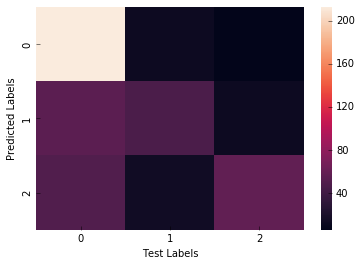

In [222]:

xcm=confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
xcm=numpy.array(xcm)
ax = sns.heatmap(xcm)
plt.xlabel('Test Labels')
plt.ylabel('Predicted Labels')
#plt.show()
plt.savefig('ConfusionMatrix')